


<a href="https://colab.research.google.com/drive/1WBUiLV0pAcmQY0NFdOEU4Q0Sahe1BHKl?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [1]:
# Install libraries for augmentation and dataset
!pip install -q albumentations tensorflow-datasets


In [2]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Load dataset (we'll use smallnorb dataset for documents)

dataset, info = tfds.load('smallnorb', split='train', shuffle_files=True, with_info=True)

print("Dataset Loaded")
print("Features:", info.features)
print("Number of samples:", info.splits['train'].num_examples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/incomplete.CUK660_2.0.0/smallnorb-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/incomplete.CUK660_2.0.0/smallnorb-test.tfrecord*...:   0%|      …

Dataset smallnorb downloaded and prepared to /root/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.
Dataset Loaded
Features: FeaturesDict({
    'image': Image(shape=(96, 96, 1), dtype=uint8),
    'image2': Image(shape=(96, 96, 1), dtype=uint8),
    'instance': ClassLabel(shape=(), dtype=int64, num_classes=10),
    'label_azimuth': ClassLabel(shape=(), dtype=int64, num_classes=18),
    'label_category': ClassLabel(shape=(), dtype=int64, num_classes=5),
    'label_elevation': ClassLabel(shape=(), dtype=int64, num_classes=9),
    'label_lighting': ClassLabel(shape=(), dtype=int64, num_classes=6),
})
Number of samples: 24300


In [6]:
X = []
y = []

# Convert tf.data.Dataset to NumPy arrays (images and labels)
for example in tfds.as_numpy(dataset.take(5000)):
    X.append(example['image'])                  # grayscale image
    y.append(example['label_category'])         # correct label key

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


X shape: (5000, 96, 96, 1)
y shape: (5000,)
Unique labels: [0 1 2 3 4]


In [7]:
# Normalize pixel values to [0,1]
X = X / 255.0

# Print range check
print("Min pixel value:", np.min(X))
print("Max pixel value:", np.max(X))


Min pixel value: 0.0
Max pixel value: 0.9882352941176471


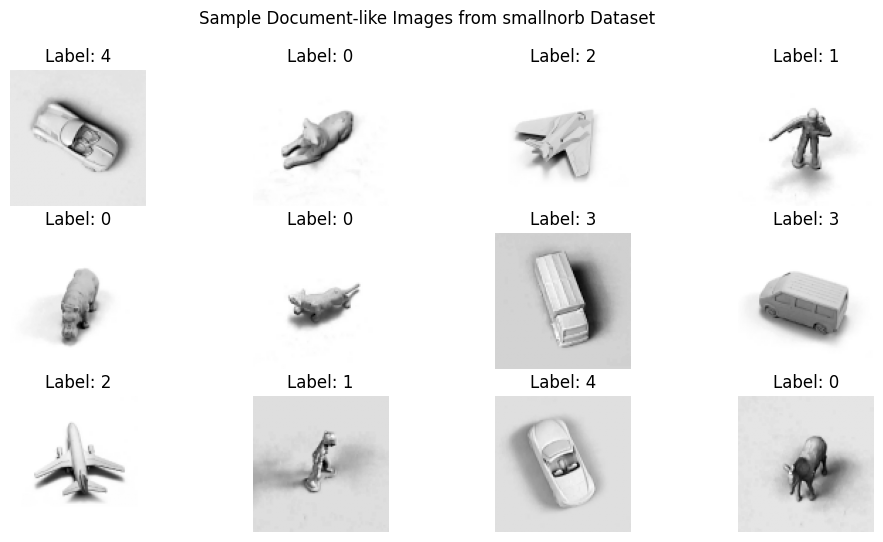

In [8]:
# Plot some examples
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.suptitle("Sample Document-like Images from smallnorb Dataset")
plt.show()


In [9]:
# Define augmentation pipeline
augment_pipeline = A.Compose([
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
# Apply augmentation to entire dataset
X_aug = []

for img in X:
    img_aug = augment_pipeline(image=(img * 255).astype(np.uint8))['image']
    img_aug = img_aug / 255.0  # Re-normalize
    X_aug.append(img_aug)

X_aug = np.array(X_aug)

print("Augmented Dataset Shape:", X_aug.shape)


Augmented Dataset Shape: (5000, 96, 96, 1)


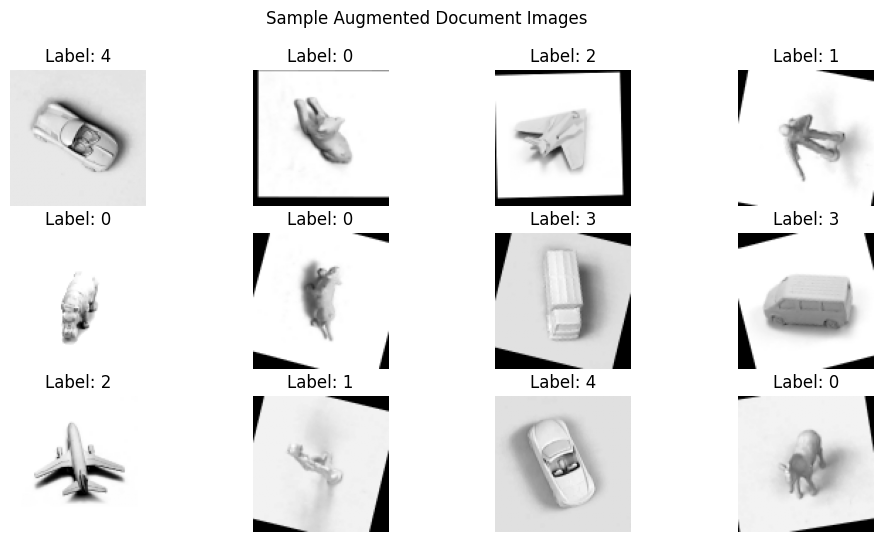

In [11]:
# Plot some augmented images
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_aug[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.suptitle("Sample Augmented Document Images")
plt.show()


In [12]:
# Split original and augmented separately for comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_aug, _, y_train_aug, _ = train_test_split(X_aug, y, test_size=0.2, random_state=42)


In [13]:
def build_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
model_raw = build_cnn_model(X_train.shape[1:], num_classes=len(np.unique(y)))

history_raw = model_raw.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=2
)


Epoch 1/15
125/125 - 7s - 52ms/step - accuracy: 0.3920 - loss: 1.3659 - val_accuracy: 0.6590 - val_loss: 0.8578
Epoch 2/15
125/125 - 1s - 9ms/step - accuracy: 0.7085 - loss: 0.7132 - val_accuracy: 0.7280 - val_loss: 0.6002
Epoch 3/15
125/125 - 1s - 9ms/step - accuracy: 0.8342 - loss: 0.4524 - val_accuracy: 0.8830 - val_loss: 0.3220
Epoch 4/15
125/125 - 1s - 9ms/step - accuracy: 0.9235 - loss: 0.2475 - val_accuracy: 0.9420 - val_loss: 0.1993
Epoch 5/15
125/125 - 1s - 10ms/step - accuracy: 0.9548 - loss: 0.1549 - val_accuracy: 0.9410 - val_loss: 0.1595
Epoch 6/15
125/125 - 1s - 9ms/step - accuracy: 0.9725 - loss: 0.0961 - val_accuracy: 0.9700 - val_loss: 0.1046
Epoch 7/15
125/125 - 1s - 9ms/step - accuracy: 0.9822 - loss: 0.0677 - val_accuracy: 0.9680 - val_loss: 0.0921
Epoch 8/15
125/125 - 1s - 9ms/step - accuracy: 0.9875 - loss: 0.0451 - val_accuracy: 0.9830 - val_loss: 0.0636
Epoch 9/15
125/125 - 1s - 11ms/step - accuracy: 0.9930 - loss: 0.0327 - val_accuracy: 0.9720 - val_loss: 0.079

In [15]:
model_aug = build_cnn_model(X_train_aug.shape[1:], num_classes=len(np.unique(y)))

history_aug = model_aug.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=2
)


Epoch 1/15
125/125 - 4s - 31ms/step - accuracy: 0.3532 - loss: 1.5004 - val_accuracy: 0.6340 - val_loss: 1.0820
Epoch 2/15
125/125 - 1s - 11ms/step - accuracy: 0.6015 - loss: 0.9921 - val_accuracy: 0.7440 - val_loss: 0.6886
Epoch 3/15
125/125 - 1s - 11ms/step - accuracy: 0.7182 - loss: 0.7497 - val_accuracy: 0.8350 - val_loss: 0.4637
Epoch 4/15
125/125 - 1s - 9ms/step - accuracy: 0.7977 - loss: 0.5563 - val_accuracy: 0.9090 - val_loss: 0.3228
Epoch 5/15
125/125 - 1s - 10ms/step - accuracy: 0.8497 - loss: 0.4263 - val_accuracy: 0.9030 - val_loss: 0.2671
Epoch 6/15
125/125 - 1s - 10ms/step - accuracy: 0.8760 - loss: 0.3487 - val_accuracy: 0.9090 - val_loss: 0.2416
Epoch 7/15
125/125 - 1s - 10ms/step - accuracy: 0.8960 - loss: 0.2952 - val_accuracy: 0.9400 - val_loss: 0.1803
Epoch 8/15
125/125 - 1s - 9ms/step - accuracy: 0.9195 - loss: 0.2263 - val_accuracy: 0.9490 - val_loss: 0.1575
Epoch 9/15
125/125 - 1s - 9ms/step - accuracy: 0.9383 - loss: 0.1775 - val_accuracy: 0.9380 - val_loss: 0.

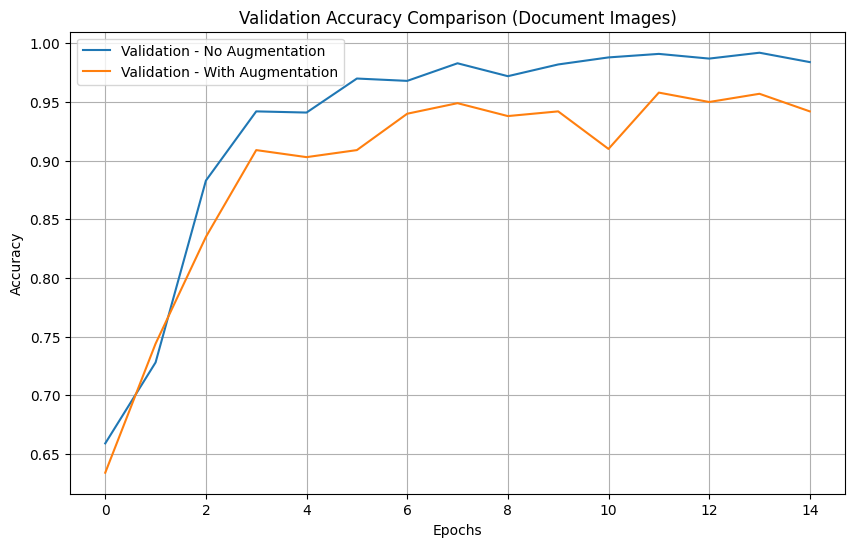

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history_raw.history['val_accuracy'], label="Validation - No Augmentation")
plt.plot(history_aug.history['val_accuracy'], label="Validation - With Augmentation")
plt.title("Validation Accuracy Comparison (Document Images)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [17]:
# Evaluate both models
test_acc_raw = model_raw.evaluate(X_test, y_test, verbose=0)[1]
test_acc_aug = model_aug.evaluate(X_test, y_test, verbose=0)[1]

print(f"Test Accuracy without augmentation: {test_acc_raw:.4f}")
print(f"Test Accuracy with augmentation: {test_acc_aug:.4f}")


Test Accuracy without augmentation: 0.9840
Test Accuracy with augmentation: 0.9420


In [19]:
# Make predictions
y_pred_raw = model_raw.predict(X_test).argmax(axis=1)
y_pred_aug = model_aug.predict(X_test).argmax(axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Confusion Matrix - No Augmentation


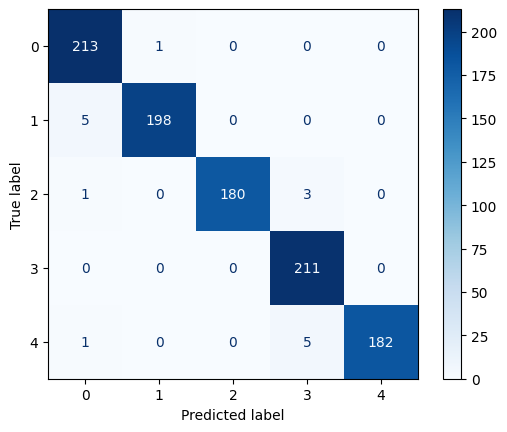

Confusion Matrix - With Augmentation


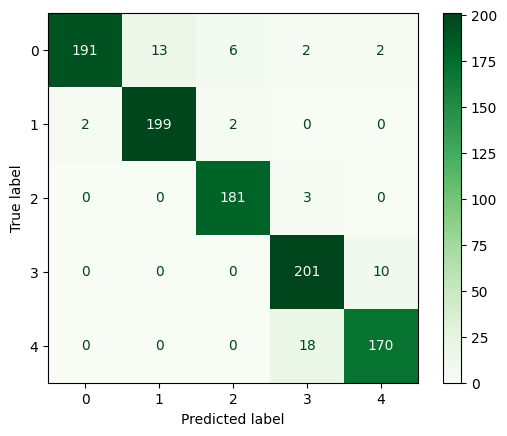

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Raw
cm_raw = confusion_matrix(y_test, y_pred_raw)
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
print("Confusion Matrix - No Augmentation")
disp_raw.plot(cmap="Blues")
plt.grid(False)
plt.show()

# Augmented
cm_aug = confusion_matrix(y_test, y_pred_aug)
disp_aug = ConfusionMatrixDisplay(confusion_matrix=cm_aug)
print("Confusion Matrix - With Augmentation")
disp_aug.plot(cmap="Greens")
plt.grid(False)
plt.show()


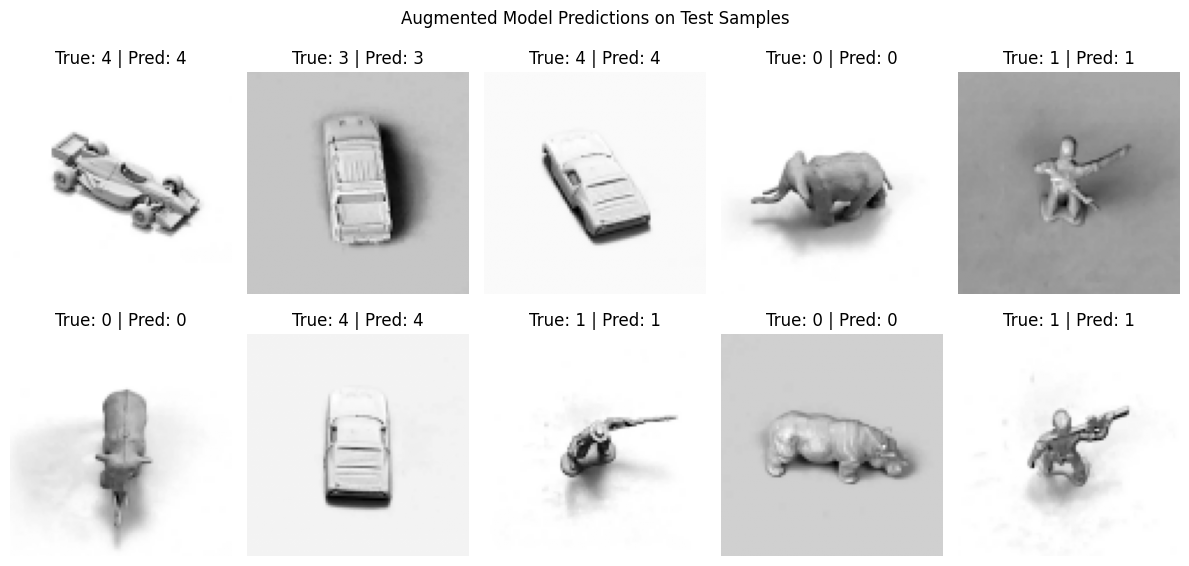

In [21]:
# Show a few predictions from augmented model
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[i]} | Pred: {y_pred_aug[i]}")
    plt.axis('off')
plt.suptitle("Augmented Model Predictions on Test Samples")
plt.tight_layout()
plt.show()
